In [136]:
from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error

# rdkit mols are displayed as images
from rdkit.Chem.Draw import IPythonConsole

from rdkit.Chem import AllChem as Chem
from rdkit import DataStructs
from rdkit.Chem.SaltRemover import SaltRemover

# descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# plots
from matplotlib import pyplot
import seaborn

# other packages
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Modely

In [81]:
df = pd.read_csv('VEGF2.csv') # pIC50
df = df.drop(['tid', 'standard_type', 'confidence_score', 'cmpd_pref_name', 'activity_comment'], axis=1)
df['mol'] = [Chem.MolFromSmiles(i) for i in df['canonical_smiles']]

## Standardiation

In [23]:
sr = SaltRemover() # from rdkit
m = Chem.MolFromSmiles("[Na+].C(=O)[O-]")
print(Chem.MolToSmiles(sr(m)))

O=C[O-]


In [24]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [25]:
smis=("c1cccc[nH+]1",
      "C[N+](C)(C)C","c1ccccc1[NH3+]",
      "CC(=O)[O-]","c1ccccc1[O-]",
      "CCS",
      "C[N-]S(=O)(=O)C",
      "C[N-]C=C","C[N-]N=C",
      "c1ccc[n-]1",
      "CC[N-]C(=O)CC")
for smi in smis:
    (molSmiles, neutralised) = NeutraliseCharges(Chem.MolFromSmiles(smi))
    print(smi + "->" + Chem.MolToSmiles(molSmiles))

c1cccc[nH+]1->c1ccncc1
C[N+](C)(C)C->C[N+](C)(C)C
c1ccccc1[NH3+]->Nc1ccccc1
CC(=O)[O-]->CC(=O)O
c1ccccc1[O-]->Oc1ccccc1
CCS->CCS
C[N-]S(=O)(=O)C->CNS(C)(=O)=O
C[N-]C=C->C=CNC
C[N-]N=C->C=NNC
c1ccc[n-]1->c1cc[nH]c1
CC[N-]C(=O)CC->CCNC(=O)CC


In [26]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic
def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

## Standardizovane, filtrovane ligandy

In [82]:
st = []
for i in range(len(df)):
    stdmol = standardize(df.mol[i])
    st.append(stdmol)
df['standard'] = st

In [83]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6715 entries, 0 to 6714
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cmpd_chembl_id    6715 non-null   object 
 1   canonical_smiles  6715 non-null   object 
 2   value             6715 non-null   float64
 3   mol               6715 non-null   object 
 4   standard          6696 non-null   object 
dtypes: float64(1), object(4)
memory usage: 262.4+ KB


In [84]:
len(df) - 6696

19

In [85]:
df = df.dropna()

# Models

In [131]:
def scoring(model, X_test, y_test):   
    y_pred = model.predict(X_test)
    score = model.score(X_test,y_test)
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    print('score: ', score)
    print('Mean Absolute Error:', MAE)
    print('Mean Squared Error:', MSE)
    print('Root Mean Squared Error:', RMSE)
    return score, MAE, MSE, RMSE

## MQN

In [95]:
df2 = df.join(pd.DataFrame((rdMolDescriptors.MQNs_(mol) for mol in df["standard"]),
                          columns=[*(f"MQN_{x}" for x in range(1,43))])
            )
df2 = df2.dropna()

In [99]:
trainset, testset = ms.train_test_split(df2[df2["value"]>0])

In [100]:
#RFR = RandomForestRegressor()
#RFR.fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["value"])
#trainset['prediction_rf'] = RFR.predict(trainset[(f"MQN_{x}" for x in range(1, 43))])

In [119]:
model_dt_mqn = DecisionTreeRegressor().fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["value"])
model_rf_mqn = RandomForestRegressor(random_state=1).fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["value"])
model_nn_mqn = MLPRegressor(random_state=1, max_iter=900).fit(trainset[(f"MQN_{x}" for x in range(1, 43))], trainset["value"])

In [120]:
y_pred_dt_mqn = model_dt_mqn.predict(trainset[(f"MQN_{x}" for x in range(1, 43))])
y_pred_rf_mqn = model_rf_mqn.predict(trainset[(f"MQN_{x}" for x in range(1, 43))])
y_pred_nn_mqn = model_nn_mqn.predict(trainset[(f"MQN_{x}" for x in range(1, 43))])

In [122]:
y_t = trainset.value

[Text(0.5, 0, 'predicted')]

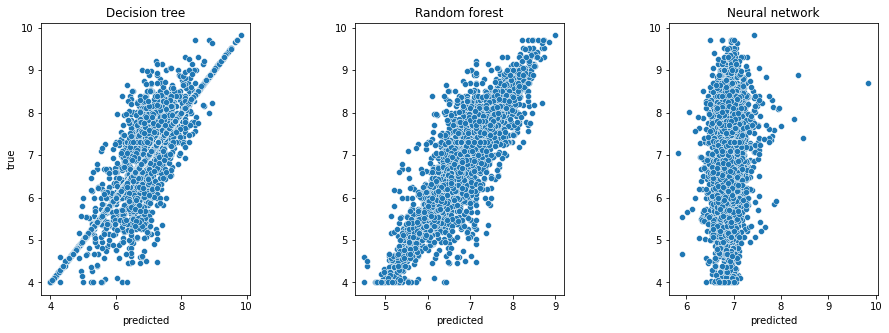

In [124]:
fig, axs = plt.subplots(ncols=3,figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5)

sns.scatterplot(x = y_pred_dt_mqn.ravel(), y = y_t.ravel(), ax=axs[0]).set_title('Decision tree')
sns.scatterplot(x = y_pred_rf_mqn.ravel(), y = y_t.ravel(), ax=axs[1]).set_title('Random forest')
sns.scatterplot(x = y_pred_nn_mqn.ravel(), y = y_t.ravel(), ax=axs[2]).set_title('Neural network')

axs[0].set(xlabel="predicted", ylabel = "true")
axs[1].set(xlabel="predicted")
axs[2].set(xlabel="predicted")

## Morgan

In [132]:
y = np.array(df.value).ravel()
x = np.array(finger)
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=1)

In [134]:
model_dt = DecisionTreeRegressor().fit(X_train, y_train)
model_rf = RandomForestRegressor(random_state=1).fit(X_train, y_train)
model_nn = MLPRegressor(random_state=1, max_iter=900).fit(X_train, y_train) 

In [93]:
y_pred_dt = model_dt.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_nn = model_nn.predict(X_test)

[Text(0.5, 0, 'predicted')]

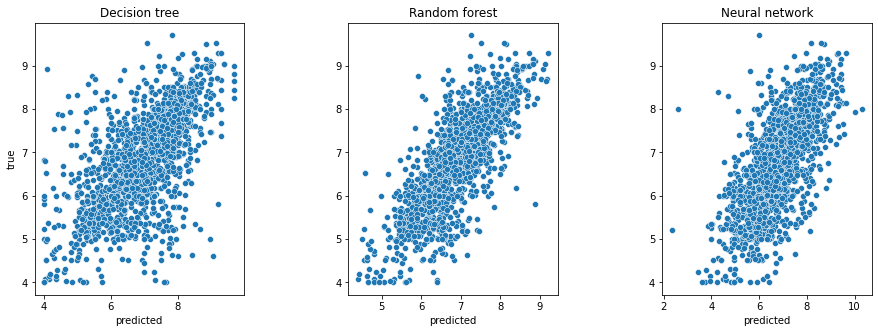

In [125]:
fig, axs = plt.subplots(ncols=3,figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5)

sns.scatterplot(x = y_pred_dt.ravel(), y = y_test.ravel(), ax=axs[0]).set_title('Decision tree')
sns.scatterplot(x = y_pred_rf.ravel(), y = y_test.ravel(), ax=axs[1]).set_title('Random forest')
sns.scatterplot(x = y_pred_nn.ravel(), y = y_test.ravel(), ax=axs[2]).set_title('Neural network')

axs[0].set(xlabel="predicted", ylabel = "true")
axs[1].set(xlabel="predicted")
axs[2].set(xlabel="predicted")

In [137]:
randForestScore = scoring(model_rf, X_test, y_test)

score:  0.6373586716327373
Mean Absolute Error: 0.48453379740068075
Mean Squared Error: 0.43942898425810395
Root Mean Squared Error: 0.6628943990245384


In [138]:
decTreeScore = scoring(model_dt, X_test, y_test)

score:  0.26675216246282474
Mean Absolute Error: 0.6474944128188912
Mean Squared Error: 0.888509740213878
Root Mean Squared Error: 0.9426079461864715


In [139]:
mlpScore = scoring(model_nn, X_test, y_test)

score:  0.41436484056399847
Mean Absolute Error: 0.6260630970816667
Mean Squared Error: 0.7096407472790038
Root Mean Squared Error: 0.8424017730744658
